<a href="https://colab.research.google.com/github/jpatrickweller/Data_Challenges/blob/main/Ice_Cream_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Import the data
def parser(s):
    return dt.datetime.strptime(s, '%Y-%m-%d')

url = 'https://raw.githubusercontent.com/ritvikmath/Time-Series-Analysis/master/ice_cream.csv'
icdf = pd.read_csv(url, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
icdf.rename('production', inplace=True)
icdf = icdf.asfreq(pd.infer_freq(icdf.index))

icdf

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 577, dtype: float64

In [ ]:
# # Let's rename the columns first
# icdf.rename(columns={'DATE':'date','IPN31152N':'production'}, inplace=True)

# # Convert the date to datetime
# icdf['date'] = pd.to_datetime(icdf['date'])

# # Set date as the index
# icdf.set_index(keys='date', inplace=True)

# icdf

In [ ]:
# Let's narrow our range, just for practical purposes
start_date = pd.to_datetime('2010-01-01')
icdf = icdf[start_date::]

icdf

DATE
2010-01-01     91.2895
2010-02-01    110.4994
2010-03-01    127.0971
2010-04-01    132.6468
2010-05-01    134.5576
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 121, dtype: float64

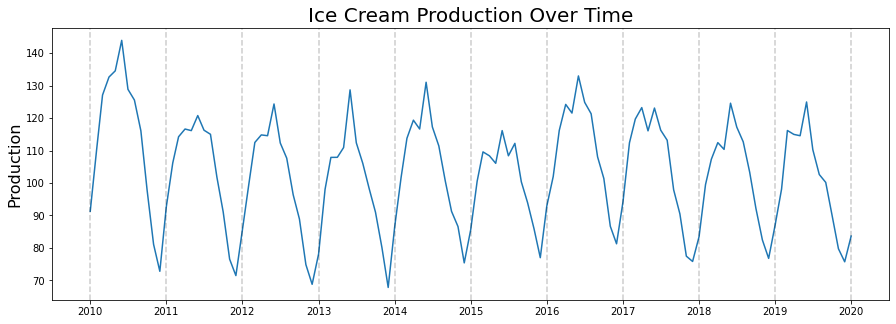

In [ ]:
# Plot this data!

def plot_timeseries(s):
    plt.figure(figsize=(15,5))
    plt.plot(s)
    plt.title('Ice Cream Production Over Time', fontsize=20)
    plt.ylabel('Production', fontsize=16)
    for year in range(2010,2021):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=.2)

plot_timeseries(icdf)

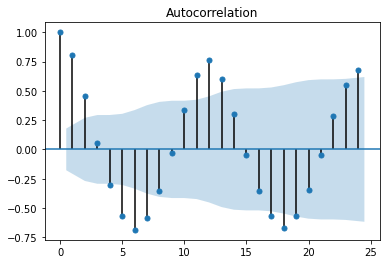

In [ ]:
acf_plot = plot_acf(icdf, lags=24)

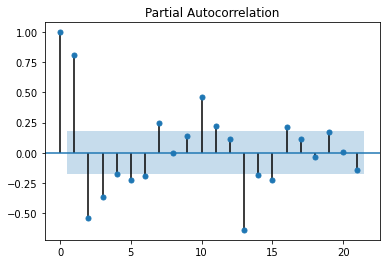

In [ ]:
pacf_plot = plot_pacf(icdf)

In [ ]:
# based on the pacf above, we can start with an AR model with legs = 1, 2, 3

In [ ]:
# Train/test split
import datetime as dt

train_end = dt.datetime(2016,12,1)
test_end = dt.datetime(2019,12,1)

train_data = icdf[:train_end]
test_data = icdf[train_end + dt.timedelta(days=1):test_end]

In [ ]:
from statsmodels.tsa.arima_model import ARMA

# create the model
model = ARMA(train_data, order=(3,0))

In [ ]:
# fit the model
from time import time

start = time()
model_fit = model.fit()
end = time()
print(f'Model Fitting Time: {end - start} ')

Model Fitting Time: 0.07872796058654785 


In [ ]:
# summary of the model

print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                   84
Model:                     ARMA(3, 0)   Log Likelihood                -294.008
Method:                       css-mle   S.D. of innovations              7.903
Date:                Mon, 01 Mar 2021   AIC                            598.015
Time:                        03:10:21   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5080      2.176     47.575      0.000      99.244     107.772
ar.L1.production     1.0488      0.099     10.573      0.000       0.854       1.243
ar.L2.production    -0.0532 

In [ ]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

print(pred_start_date)
print(pred_end_date)

2017-01-01 00:00:00
2019-12-01 00:00:00


In [ ]:
# get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

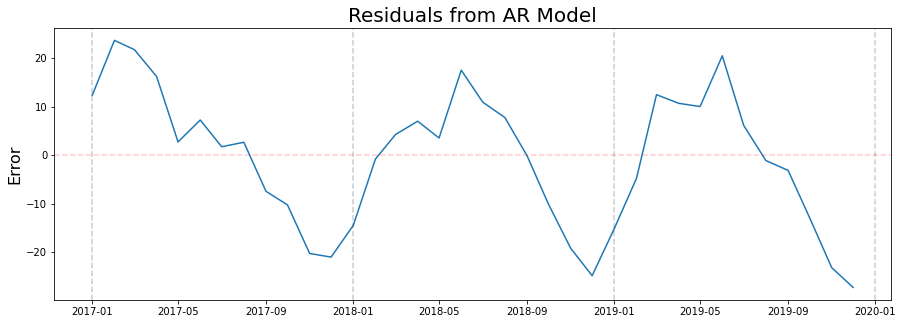

Mean absolute percent error: 0.1211
Mean squared error: 13.89


In [ ]:
# plot the residuals!

def plot_residuals(residuals, observations):
    plt.figure(figsize=(15,5))
    plt.plot(residuals)
    plt.title('Residuals from AR Model', fontsize=20)
    plt.ylabel('Error', fontsize=16)
    plt.axhline(0, color='r', linestyle='--', alpha=0.2)
    for year in range(2017, 2021):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    plt.show()

    print(f"Mean absolute percent error: {round(np.mean(abs(residuals/observations)),4)}")
    print(f"Mean squared error: {np.sqrt(np.mean(residuals**2)).round(2)}")

plot_residuals(residuals, test_data)

In [ ]:
# This perodicity indicates there is some structure in the data that the model 
# failed to capture (obviously).

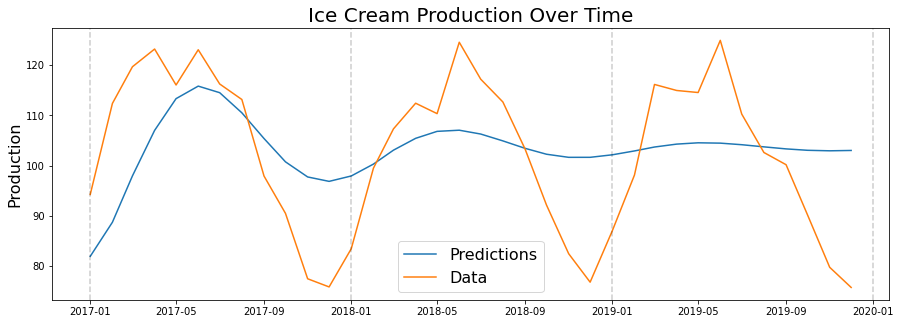

In [ ]:
# Compare the predicted and the actual values

def plot_pred_vs_observed(test_data, predictions):

    plt.figure(figsize=(15,5))
    plt.plot(predictions)
    plt.plot(test_data)
    plt.legend(('Predictions','Data'), fontsize=16)
    plt.title('Ice Cream Production Over Time', fontsize=20)
    plt.ylabel('Production', fontsize=16)
    for year in range(2017,2021):
        plt.axvline(x=pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

plot_pred_vs_observed(test_data, predictions)

### Rolling Forecast Origin

Idea: predict just 1 month in advance at a time.

So train on months 1, 2, ... k-3 -> predict month k-2

Then, train on months 1, 2, ... k-2 -> predict month k-1

Finally, train on months 1, 2, ... k-1 -> predict month k

Finally finally, average all the predictions

In [ ]:
# create the rolling model

predictions_rolling = pd.Series()
for end_date in test_data.index:
    train_data = icdf[:end_date]
    # train_data = icdf.production[:end_date - dt.timedelta(days=1)]
    model = ARMA(train_data, order=(3,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]
    # predictions_rolling.loc[end_date] = model_fit.predict(end_date) # This doesn't work

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


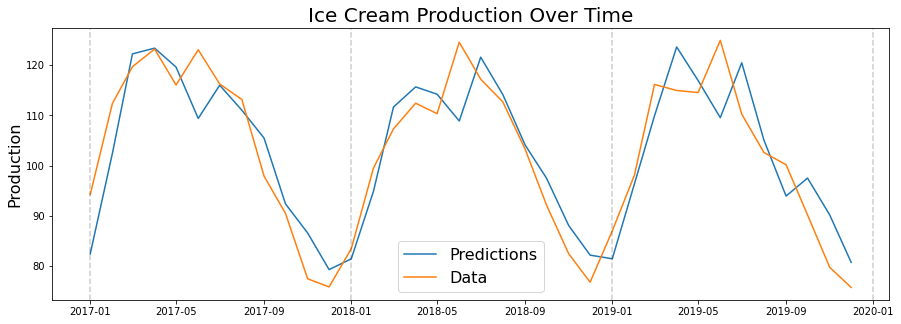

In [ ]:
plot_pred_vs_observed(test_data, predictions_rolling)

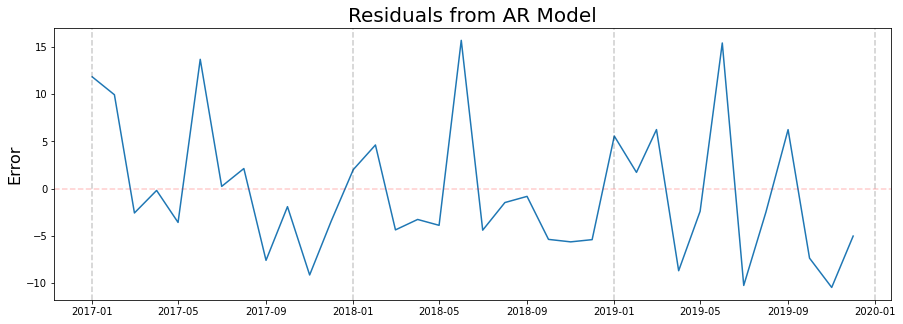

Mean absolute percent error: 0.0564
Mean squared error: 7.0


In [ ]:
# Look at residuals of new predictions

residuals_rolling = test_data - predictions_rolling
plot_residuals(residuals_rolling, test_data)